In [1]:
import copy
import numpy as np
import graphviz   # pylint: disable=g-import-not-at-top


INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'

#             1  2  3  4  5
matrix = \
np.array([[0, 1, 1, 0, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1
          [0, 0, 0, 0, 0, 0, 1],    # 2
          [0, 0, 0, 0, 1, 0, 0],    # 3
          [0, 0, 0, 0, 0, 0, 1],    # 4
          [0, 0, 0, 0, 0, 0, 1],    # 5
          [0, 0, 0, 0, 0, 0, 0]])  # output layer


In [27]:
# Operations at the vertices of the module, matches order of matrix.
#              1        2        3        4         5
#ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT]
ops=[INPUT, "1", "2", "3", "4", "5", OUTPUT]


In [28]:
def _prune(original_matrix, ops):
    """Prune the extraneous parts of the graph.

    General procedure:
      1) Remove parts of graph not connected to input.
      2) Remove parts of graph not connected to output.
      3) Reorder the vertices so that they are consecutive after steps 1 and 2.

    These 3 steps can be combined by deleting the rows and columns of the
    vertices that are not reachable from both the input and output (in reverse).
    """
    pruned_matrix = copy.deepcopy(original_matrix)
    pruned_ops = copy.deepcopy(ops)
    num_vertices = np.shape(original_matrix)[0]

    # DFS forward from input
    visited_from_input = set([0])
    frontier = [0]
    while frontier:
      top = frontier.pop()
      for v in range(top + 1, num_vertices):
        if original_matrix[top, v] and v not in visited_from_input:
          visited_from_input.add(v)
          frontier.append(v)

    # DFS backward from output
    visited_from_output = set([num_vertices - 1])
    frontier = [num_vertices - 1]
    while frontier:
      top = frontier.pop()
      for v in range(0, top):
        if original_matrix[v, top] and v not in visited_from_output:
          visited_from_output.add(v)
          frontier.append(v)

    # Any vertex that isn't connected to both input and output is extraneous to
    # the computation graph.
    extraneous = set(range(num_vertices)).difference(
        visited_from_input.intersection(visited_from_output))

    # If the non-extraneous graph is less than 2 vertices, the input is not
    # connected to the output and the spec is invalid.
    # Infeasible graph
    if len(extraneous) > num_vertices - 2:
      return

    pruned_matrix = np.delete(pruned_matrix, list(extraneous), axis=0)
    pruned_matrix = np.delete(pruned_matrix, list(extraneous), axis=1)
    for index in sorted(extraneous, reverse=True):
      del pruned_ops[index]

    return pruned_matrix, pruned_ops

In [32]:
matrix, ops = _prune(matrix, ops)

In [33]:
def visualize(matrix, ops):
    """Creates a dot graph. Can be visualized in colab directly."""
    num_vertices = np.shape(matrix)[0]
    g = graphviz.Digraph()
    g.node(str(0), 'input')
    for v in range(1, num_vertices - 1):
      g.node(str(v), ops[v])
    g.node(str(num_vertices - 1), 'output')

    for src in range(num_vertices - 1):
      for dst in range(src + 1, num_vertices):
        if matrix[src, dst]:
          g.edge(str(src), str(dst))

    return g

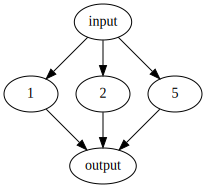

In [34]:
visualize(matrix, ops)